# Wasserstein GAN

# Introduce Library

In [7]:
import pickle
import numpy as np
import time
import tqdm
import torch
import torch.nn as nn
from torch import optim
from torch import autograd
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataset import Subset
from torch.autograd import Variable
from torch.autograd import grad as torch_grad
import matplotlib.pyplot as plt

## parameter

In [8]:
BATCH_SIZE = 10 # Batch size

## Data Load

In [9]:
# dataset
class Dataset(Dataset):
  
    def __init__(self):
        'Initialization'
        
    def __len__(self):
        'Denotes the total number of samples'
        return 1200
        #return 6 #for testing code
    
    def __getitem__(self, index):
        'Generates one sample of data'
        
        # Load data
        X = torch.load('true_data/{}.pt'.format(index))
        return X

In [10]:
from sklearn.model_selection import train_test_split
dataset = Dataset()
train_index, valid_index = train_test_split(range(len(dataset)), test_size=0.2)
train_data = Subset(dataset,train_index)
valid_data = Subset(dataset,valid_index)
dataloader_train = DataLoader(dataset = train_data, batch_size=BATCH_SIZE,
                                         shuffle=True)
dataloader_valid = DataLoader(dataset=valid_data, batch_size=BATCH_SIZE,shuffle=False)

## Model

In [11]:
# Generator
# Generator Code

class Generator(nn.Module):
    def __init__(self,nz=60,DIM=64):
        super(Generator, self).__init__()
        
        self.layer0 = nn.Sequential(
            
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, DIM * 64, kernel_size=3, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(DIM * 64),
            nn.ReLU(True))
        
        self.layer1 = nn.Sequential(
            
            nn.ConvTranspose2d(DIM * 64, DIM * 32, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(DIM * 32),
            nn.ReLU(True))
            
        self.layer2 = nn.Sequential(
            
            nn.ConvTranspose2d(DIM * 32, DIM * 16, kernel_size=3, stride=2, padding=(0,1), bias=False),
            nn.BatchNorm2d(DIM * 16),
            nn.ReLU(True))
            
        self.layer3 = nn.Sequential(
            
            nn.ConvTranspose2d( DIM * 16, DIM * 8, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(DIM * 8),
            nn.ReLU(True))
        
        self.layer4 = nn.Sequential(
            
            nn.ConvTranspose2d( DIM * 8, DIM * 4, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(DIM * 4),
            nn.ReLU(True))
        
        self.layer5 = nn.Sequential(
            
            nn.ConvTranspose2d( DIM * 4, DIM * 2, kernel_size=3, stride=2, padding=(0,1), bias=False),
            nn.BatchNorm2d(DIM * 2),
            nn.ReLU(True))
            
        self.layer6 = nn.Sequential(
            
            nn.ConvTranspose2d( DIM * 2, DIM, kernel_size=3, stride=2, padding=(1,0), bias=False),
            nn.BatchNorm2d(DIM),
            nn.ReLU(True))
            
        self.layer7 = nn.Sequential(
            
            nn.ConvTranspose2d( DIM, 1, kernel_size=(4,3), stride=2, padding=1, bias=False),
            nn.Tanh()
            
            
        )

    def forward(self, x):
        
        out = self.layer0(x)
        
        out = self.layer1(out)
        
        out = self.layer2(out)
        
        out = self.layer3(out)
        
        out = self.layer4(out)
        
        out = self.layer5(out)
        
        out = self.layer6(out)
        
        out = self.layer7(out)
        
        return out
    
    def sample_latent(self,num_samples):
        return torch.randn((num_samples,nz,1,1))

In [12]:
class Discriminator(nn.Module):
    def __init__(self,DIM=64):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # input is 1 x 330 x 261
            nn.Conv2d(1, DIM, kernel_size=3, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
        
            
            nn.Conv2d(DIM, DIM * 2, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(DIM * 2),
            nn.LeakyReLU(0.2, inplace=True),
            
            
            
            nn.Conv2d(DIM * 2, DIM * 4, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(DIM * 4),
            nn.LeakyReLU(0.2, inplace=True),
            
            
            
            nn.Conv2d(DIM * 4, DIM * 8, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(DIM * 8),
            nn.LeakyReLU(0.2, inplace=True),
            
     
            nn.Conv2d(DIM * 8, DIM * 16, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(DIM * 16),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(DIM * 16, DIM * 32, kernel_size=3, stride=2, padding=(0,1), bias=False),
            nn.BatchNorm2d(DIM * 32),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(DIM * 32, DIM * 64, kernel_size=3, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(DIM * 64),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(DIM * 64, 1, kernel_size=3, stride=1, padding=0, bias=False),
        )

    def forward(self, input):
        output = self.main(input)
        return output

In [13]:
def calc_gradient_penalty(netD, data, generated_data,gp_weight=10):
    # print "real_data: ", real_data.size(), fake_data.size
    alpha = torch.randn(data.size(0),1,1,1)
    if use_cuda:
        alpha = alpha.cuda(gpu)
    interpolates = alpha * data + ((1 - alpha) * generated_data)
    if use_cuda:
        alpha=alpha.cpu()
    interpolates = autograd.Variable(interpolates, requires_grad=True)
    disc_interpolates = netD(interpolates)
    gradients = autograd.grad(outputs=disc_interpolates, inputs=interpolates,
                              grad_outputs=torch.ones(disc_interpolates.size()).cuda(gpu) if use_cuda else torch.ones(
                                  disc_interpolates.size()),create_graph=True, retain_graph=True, only_inputs=True)[0]
    gradients = gradients.view(gradients.size(0), -1)
    #loss['gradient_norm'].append(gradients.norm(2, dim=1).mean().item())
    gradients_norm = gradients.norm(2, dim=1)
    return gp_weight * ((gradients_norm - 1) ** 2).mean()

## Training

In [14]:
netD = Discriminator()
netG = Generator()
optimizerD = optim.Adam(netD.parameters(), lr=1e-7, betas=(0.5, 0.9))
optimizerG = optim.Adam(netG.parameters(), lr=1e-7, betas=(0.5, 0.9))

In [15]:
use_cuda = True
ITERS = 10
nz=60

In [16]:
if use_cuda:
    gpu = 0
if use_cuda:
    netD = netD.cuda(gpu)
    netG = netG.cuda(gpu)

In [17]:
"""
fake_data_list = []
loss = {'GP':[],'gradient_norm':[]}
losses = {'D':[],'G':[]}
min = 10
for iteration in tqdm.tqdm(range(ITERS)):
    start_time = time.time()
    ############################
    # (1) Update D network
    ###########################
    for p in netD.parameters():  # reset requires_grad
        p.requires_grad = True  # they are set to False below in netG update
    for data in dataloader_train:
        netD.zero_grad()
        # train
        data = data.reshape(BATCH_SIZE,1,330,261)
        if use_cuda:
            data = data.cuda(gpu)
        data = autograd.Variable(data)
        D_real = netD(data)
        D_real = torch.mean(D_real)
        D_real.backward()
        if use_cuda:
            data = data.cpu()
            D_real = D_real.cpu()
        D_x = D_real.item()
        
        # Generate batch of latent vectors
        noise = torch.randn(BATCH_SIZE, nz, 1, 1)
        if use_cuda:
            noise = noise.cuda(gpu)
        noise = autograd.Variable(noise)
        fake_data = netG(noise).data
        fake_data = autograd.Variable(fake_data)
        D_fake = netD(fake_data)
        D_fake = torch.mean(D_fake)
        D_fake.backward()
        if use_cuda:
            noise = noise.cpu()
            fake_data = fake_data.cpu()
            D_fake = D_fake.cpu()
        D_G_z1 = D_fake.item()
        
        
        gradient_penalty = calc_gradient_penalty(netD, data.data, fake_data.data)
        loss['GP'].append(gradient_penalty)
        gradient_penalty.backward()
        if use_cuda:
            gradient_penalty = gradient_penalty.cpu()
        
        D_loss = D_fake - D_real + gradient_penalty
        #D_loss.backward()
        optimizerD.step()
    
    ############################
    # (2) Update G network
    ###########################
    for p in netD.parameters():
        p.requires_grad = True  # to avoid computation
    netG.zero_grad()
    if use_cuda:
        fixed_noise = fixed_noise.cuda(gpu)
    noise = autograd.Variable(fixed_noise)
    fake_data = netG(noise).data
    G = netD(fake_data)
    G_loss = torch.mean(G)
    G_loss.backward()
    if use_cuda:
        G_loss.cpu()
    D_G_z2 = torch.mean(G).item()
    optimizerG.step()
        
    print('[%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
            % (iteration, ITERS,
            D_loss.item(), G_loss.item(), D_x, D_G_z1, D_G_z2))
    # Save Losses for plotting later
    losses['G'].append(G_loss.item())
    losses['D'].append(D_loss.item())
    file1 = 'params/0625/loss_G.pkl'
    file2 = 'params/0625/loss_D.pkl'
    pickle.dump(losses['G'],open(file1,'wb'))
    pickle.dump(losses['D'],open(file2,'wb'))
    if min>G_loss:
        torch.save(netD.state_dict(),"./params/0625/netD.pth")
        torch.save(netG.state_dict(),"./params/0625/netG.pth")
        min = G_loss

    # Check how the generator is doing by saving G's output on fixed_noise
        
    with torch.no_grad():
        fake = netG(fixed_noise).detach()
        if use_cuda:
            fake=fake.cpu()
        fake_data_list.append(fake)
"""

'\nfake_data_list = []\nloss = {\'GP\':[],\'gradient_norm\':[]}\nlosses = {\'D\':[],\'G\':[]}\nmin = 10\nfor iteration in tqdm.tqdm(range(ITERS)):\n    start_time = time.time()\n    ############################\n    # (1) Update D network\n    ###########################\n    for p in netD.parameters():  # reset requires_grad\n        p.requires_grad = True  # they are set to False below in netG update\n    for data in dataloader_train:\n        netD.zero_grad()\n        # train\n        data = data.reshape(BATCH_SIZE,1,330,261)\n        if use_cuda:\n            data = data.cuda(gpu)\n        data = autograd.Variable(data)\n        D_real = netD(data)\n        D_real = torch.mean(D_real)\n        D_real.backward()\n        if use_cuda:\n            data = data.cpu()\n            D_real = D_real.cpu()\n        D_x = D_real.item()\n        \n        # Generate batch of latent vectors\n        noise = torch.randn(BATCH_SIZE, nz, 1, 1)\n        if use_cuda:\n            noise = noise.cuda

In [18]:
def main(ITERS=100):
    fake_data_list = []
    losses = []
    min = 10
    for iteration in tqdm.tqdm(range(ITERS)):
        start_time = time.time()
        ############################
        # (1) Update D network
        ###########################
        for data in dataloader_train:
            print(data.size())
            optimizerD.zero_grad()
            # train
            data = data.reshape(BATCH_SIZE,1,330,261)
            if use_cuda:
                data = data.cuda(gpu)
            data = autograd.Variable(data)
            D_real = netD(data)
            D_real = torch.mean(D_real)
            #D_real.backward(mone)
            D_x = D_real.item()

            # Generate batch of latent vectors
            noise = torch.randn(BATCH_SIZE, nz, 1, 1)
            if use_cuda:
                noise = noise.cuda(gpu)
            noise = autograd.Variable(noise)
            fake_data = netG(noise).data
            fake_data = autograd.Variable(fake_data)
            D_fake = netD(fake_data)
            D_fake = torch.mean(D_fake)
            #D_fake.backward(one)
            D_G_z1 = -D_fake.item()
            gradient_penalty = calc_gradient_penalty(netD, data.data, fake_data.data)
            #print(gradient_penalty)
            #gradient_penalty.backward()
            D_loss = D_fake - D_real + gradient_penalty
            D_loss.backward()
            optimizerD.step()
            if use_cuda:
                data=data.cpu()
                noise=noise.cpu()
            
        ############################
        # (2) Update G network
        ###########################
        optimizerG.zero_grad()
        fixed_noise = torch.randn(BATCH_SIZE, nz, 1, 1)
        if use_cuda:
            fixed_noise = fixed_noise.cuda(gpu)
        noise = autograd.Variable(fixed_noise)
        fake_data = netG(noise).data
        G = netD(fake_data)
        G_loss = torch.mean(G)
        G_loss.backward()
        D_G_z2 = torch.mean(G).item()
        optimizerG.step()
        if use_cuda:
            fixed_noise=fixed_noise.cpu()

        print('[%d/%d]\tLoss_D: %.4f'% (iteration+1, ITERS,D_loss.item()))
        # Save Losses for plotting later
        losses.append(D_loss.item())
        file = 'params/0725/loss_D.pickle'
        pickle.dump(losses,open(file,'wb'))
        torch.save(netD.state_dict(),"./params/0725/netD.pth")
        torch.save(netG.state_dict(),"./params/0725/netG.pth")

    with torch.no_grad():
        if use_cuda:
            test_noise = torch.randn(BATCH_SIZE,nz,1,1).cuda(gpu)
        fake = netG(test_noise).detach()
        if use_cuda:
            fake=fake.cpu()
        fake_data_list.append(fake)
        with open('params/0725/fake_data.pickle','wb') as f:
            pickle.dump(fake_data_list,f)

In [19]:
main(1)

  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([10, 1, 330, 261])
torch.Size([10, 1, 330, 261])
torch.Size([10, 1, 330, 261])
torch.Size([10, 1, 330, 261])
torch.Size([10, 1, 330, 261])
torch.Size([10, 1, 330, 261])
torch.Size([10, 1, 330, 261])
torch.Size([10, 1, 330, 261])
torch.Size([10, 1, 330, 261])
torch.Size([10, 1, 330, 261])
torch.Size([10, 1, 330, 261])
torch.Size([10, 1, 330, 261])
torch.Size([10, 1, 330, 261])
torch.Size([10, 1, 330, 261])
torch.Size([10, 1, 330, 261])
torch.Size([10, 1, 330, 261])
torch.Size([10, 1, 330, 261])
torch.Size([10, 1, 330, 261])
torch.Size([10, 1, 330, 261])
torch.Size([10, 1, 330, 261])
torch.Size([10, 1, 330, 261])
torch.Size([10, 1, 330, 261])
torch.Size([10, 1, 330, 261])
torch.Size([10, 1, 330, 261])
torch.Size([10, 1, 330, 261])
torch.Size([10, 1, 330, 261])
torch.Size([10, 1, 330, 261])
torch.Size([10, 1, 330, 261])
torch.Size([10, 1, 330, 261])
torch.Size([10, 1, 330, 261])
torch.Size([10, 1, 330, 261])
torch.Size([10, 1, 330, 261])
torch.Size([10, 1, 330, 261])
torch.Size

100%|██████████| 1/1 [00:46<00:00, 46.16s/it]


In [28]:
with open('params/0725/loss_D.pickle','rb') as f:
    loss_D = pickle.load(f)
"""
with open('params/0725/fake_data.pickle','rb') as f:
    fake_data = pickle.load(f)
"""

"\nwith open('params/0725/fake_data.pickle','rb') as f:\n    fake_data = pickle.load(f)\n"

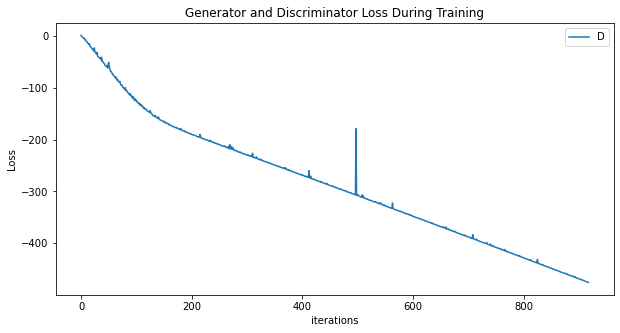

In [29]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(loss_D,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [31]:
if use_cuda:
    test_noise = torch.randn(BATCH_SIZE,nz,1,1).cuda(gpu)
netG.load_state_dict(torch.load("./params/0725/netG.pth"))
fake = netG(test_noise).detach()
if use_cuda:
    fake=fake.cpu()
with open('params/0725/fake_data.pickle','wb') as f:
    pickle.dump(fake,f)

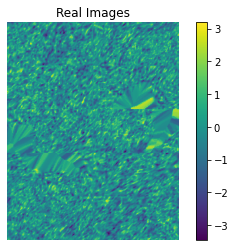

In [32]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader_valid))

# Plot the real images
plt.axis("off")
plt.title("Real Images")
plt.imshow(real_batch[0][0])
plt.colorbar()
plt.show()

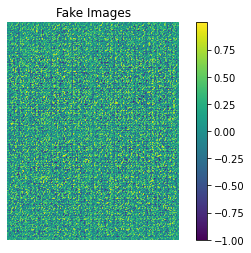

In [33]:
# Plot the fake images from the last epoch
fake_image = fake[0][0]
plt.axis("off")
plt.title("Fake Images")
plt.imshow(fake_image)
plt.colorbar()
plt.show()

In [27]:
real_batch.shape

torch.Size([10, 1, 330, 261])

In [28]:
fake_batch=torch.tensor(fake_data[0])

/home/chikazoe/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """Entry point for launching an IPython kernel.


In [29]:
fake_batch.shape

torch.Size([10, 1, 330, 261])

In [39]:
def SAD(real,fake):
    x=len(real)
    y=len(real[0])
    sum=0
    for i in range(x):
        for j in range(y):
            sum+=abs(real[i][j]-fake[i][j])
    return sum

In [40]:
real=real_batch[0][0]
fake=fake_batch[0][0]

In [41]:
fake.shape

torch.Size([330, 261])

In [42]:
colleration = SAD(real,fake)

In [46]:
def NCC(real,fake):
    x=len(real)
    y=len(real[0])
    sum_xy=0
    sum_x=0
    sum_y=0
    for j in range(y):
        for i in range(x):
            sum_xy+=real[i][j]*fake[i][j]
            sum_x+=real[i][j]**2
            sum_y+=fake[i][j]**2
    return sum_xy/torch.sqrt(sum_x*sum_y)

In [47]:
colleration = NCC(real,fake)
print(colleration)

tensor(-0.0349)


In [52]:
data = torch.load("./../../../chikazoeG_NAS/Ishii/from_remote/to_local/fake.pt")

In [58]:
len(data[0][0][0])

330

In [71]:
fake_ishii=data[33][9]
fake_ishii=torch.tensor(fake_ishii)

/home/chikazoe/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


TypeError: Invalid shape (1, 330, 261) for image data

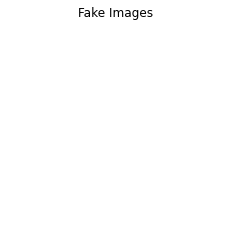

In [72]:
# Plot the fake images from the last epoch
plt.axis("off")
plt.title("Fake Images")
plt.imshow(fake_ishii.cpu())
plt.colorbar()
plt.show()

In [67]:
colleration = NCC(real,fake_ishii)
print(colleration)

tensor(-0.0094, device='cuda:0', dtype=torch.float64)


In [10]:
%load_ext memory_profiler

The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler


In [11]:
from wgan import main
%mprun -f main main(10)

  0%|          | 0/10 [00:00<?, ?it/s]

[0/10]	Loss_D: 6.7962	Loss_G: 0.4349	D(x): 0.4821	D(G(z)): 0.4642 / 0.4349


 10%|█         | 1/10 [00:26<04:01, 26.86s/it]

[1/10]	Loss_D: 6.5395	Loss_G: 0.3983	D(x): 0.3867	D(G(z)): 0.4436 / 0.3983


 20%|██        | 2/10 [00:54<03:36, 27.10s/it]

[2/10]	Loss_D: 7.2420	Loss_G: 0.3282	D(x): 0.4068	D(G(z)): 0.3680 / 0.3282


 30%|███       | 3/10 [01:39<03:53, 33.30s/it]

*** KeyboardInterrupt exception caught in code being profiled.


In [4]:
import psutil

mem = psutil.virtual_memory() 
print(mem.percent)

16.5


In [8]:
# メモリ使用量を取得 
print(mem.used)

# メモリ空き容量を取得
print(mem.available)

4920496128
28061274112


In [9]:
import sys

print("{}{: >25}{}{: >10}{}".format('|','Variable Name','|','Memory','|'))
print(" ------------------------------------ ")
for var_name in dir():
    if not var_name.startswith("_"):
        print("{}{: >25}{}{: >10}{}".format('|',var_name,'|',sys.getsizeof(eval(var_name)),'|'))

|            Variable Name|    Memory|
 ------------------------------------ 
|                       In|       200|
|                      Out|       248|
|                     exit|        64|
|              get_ipython|        72|
|                     main|       144|
|                      mem|       144|
|                   psutil|        88|
|                     quit|        64|
|                      sys|        88|
|                 var_name|        57|
